In [11]:
import numpy as np
import astra
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy.sparse.linalg import LinearOperator, lsqr
from scipy.sparse.linalg import LinearOperator, cg
import pywt
import cv2


from skimage.transform import radon, iradon
from skimage.metrics import structural_similarity as ssim

# Q1 Calculate the Radon transform of an image and test the back-projection method.

### 1. Show a picture of f_true

In [13]:
# 1. Load the Shepp-Logan phantom image
SLphan_img = np.load('SLphan.npy') # 128 x 128
f_true = SLphan_img
img_size = 128

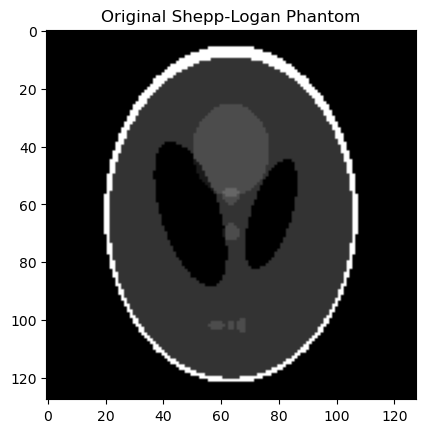

In [14]:
# Display the original image
plt.figure()
plt.imshow(f_true, cmap='gray')
# plt.imshow(f_true)
plt.title("Original Shepp-Logan Phantom")
plt.show()

### 2. Generate the Radon Transform

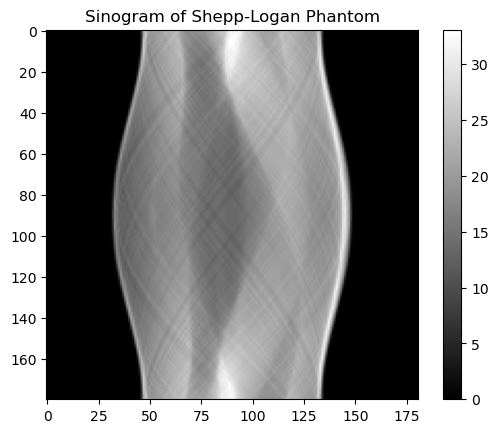

Size of the sinogram: (180, 181)


In [15]:
v, h = f_true.shape
vol_geom = astra.create_vol_geom(v, h)
det_count = int(np.sqrt(v**2 + h**2))  # Calculate diagonal length and convert to an integer for detector count

angles = np.linspace(0, np.pi, 180, endpoint=False)  # Using np.pi because ASTRA uses radians
proj_geom = astra.create_proj_geom('parallel', 1.0, det_count, angles)

# Set up the projector
projector_id = astra.create_projector('strip', proj_geom, vol_geom)

# Create a sinogram from the phantom image using the projector
sinogram_id, sinogram = astra.create_sino(f_true, projector_id)

plt.figure()
plt.imshow(sinogram, cmap='gray')
plt.title("Sinogram of Shepp-Logan Phantom")
plt.colorbar()
plt.show()

# Output the size of the sinogram
print("Size of the sinogram:", sinogram.shape)



### 3. Unfiltered Back-Projection

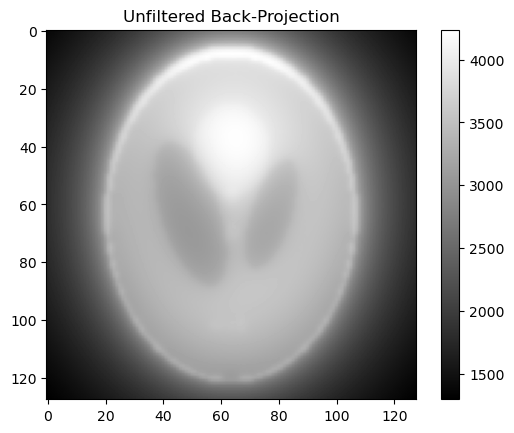

Size of the back-projected reconstructed image: (128, 128)


In [16]:
# Perform unfiltered back-projection
rec_id = astra.data2d.create('-vol', vol_geom)
cfg = astra.astra_dict('BP')  # Use 'BP_CUDA' if using CUDA for GPU acceleration
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = projector_id  # This is required for setting up the back-projection

bp_alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(bp_alg_id)
f_unfiltered_bp = astra.data2d.get(rec_id)

# Display the unfiltered back-projection
plt.figure()
plt.imshow(f_unfiltered_bp, cmap='gray')
plt.title("Unfiltered Back-Projection")
plt.colorbar()
plt.show()



print('Size of the back-projected reconstructed image:', f_unfiltered_bp.shape)


### 4. Filtered Back-Projection

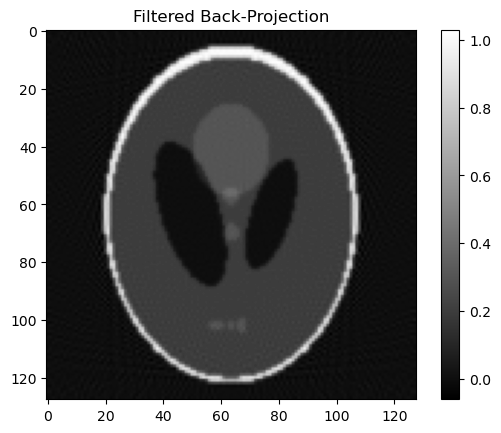

In [17]:
# Filtered back-projection
cfg['type'] = 'FBP'  # Change the type to FBP for filtered back-projection
fbp_alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(fbp_alg_id)
f_filtered_bp = astra.data2d.get(rec_id)

plt.figure()
plt.imshow(f_filtered_bp, cmap='gray')
#plt.imshow(f_filtered_bp)
plt.title("Filtered Back-Projection")
plt.colorbar()
plt.show()

In [18]:
# Calculate and display the Mean Squared Error (MSE)
mse = np.mean((f_true - f_filtered_bp)**2)
print('Mean Squared Error (MSE):', mse)

Mean Squared Error (MSE): 0.003209254652032573


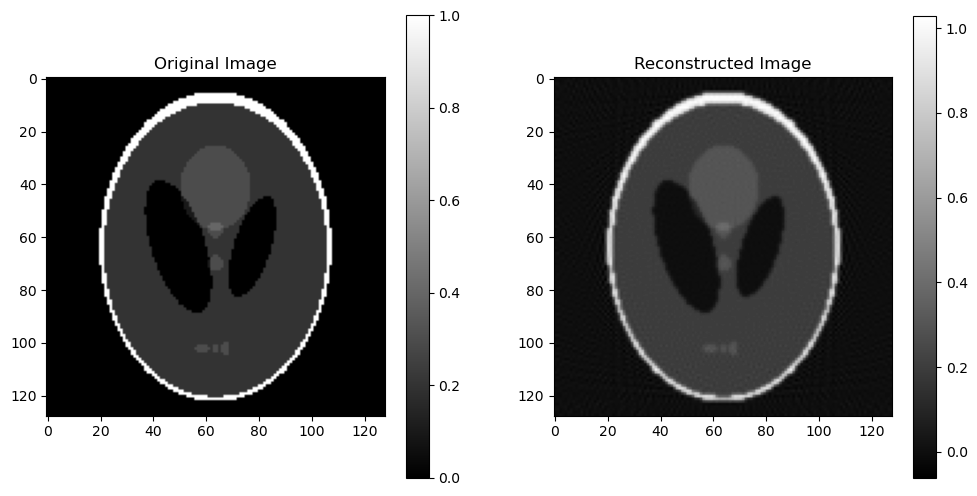

In [19]:
# Display images for comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(f_true, cmap='gray')
plt.title('Original Image')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(f_filtered_bp, cmap='gray')
plt.title('Reconstructed Image')
plt.colorbar()

plt.show()



### 5. Adding Noise and Testing Reconstruction

/Users/wangyue/opt/anaconda3/lib/python3.8/site-packages/astra/functions.py:115: RuntimeWarning: divide by zero encountered in log
  sinogram_out = -max_sinogramRaw * np.log(sinogramCT_D)


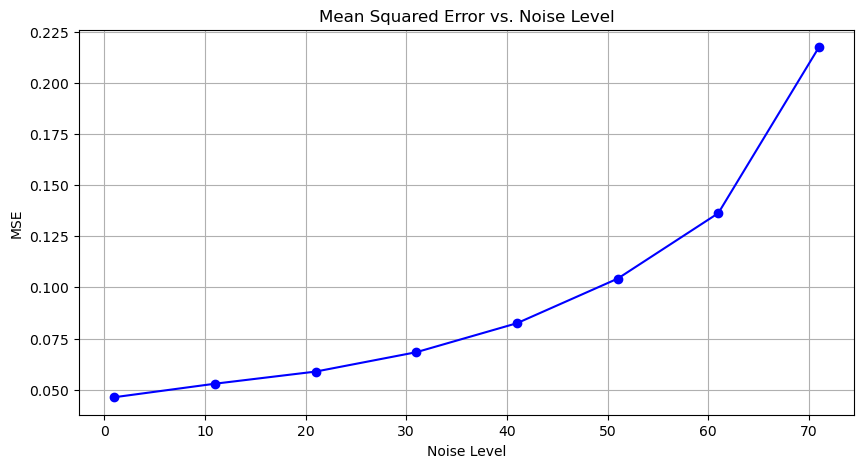

In [20]:


# Define the noise levels
noise_levels = np.arange(1, 101, 10) 
mse_results = []


# Loop through different noise levels
for theta in noise_levels:

    # Add noise to the sinogram
    gNoisy = astra.functions.add_noise_to_sino(sinogram, theta)
    
    # Create a data ID for the noisy sinogram
    gNoisy_id = astra.data2d.create('-sino', proj_geom, gNoisy)
    
    # Set up the filtered back-projection for the noisy sinogram
    rec_id_noisy = astra.data2d.create('-vol', vol_geom)
    cfg_noisy = astra.astra_dict('FBP')
    cfg_noisy['ReconstructionDataId'] = rec_id_noisy
    cfg_noisy['ProjectionDataId'] = gNoisy_id
    cfg_noisy['ProjectorId'] = projector_id 
    # Create and run the FBP algorithm
    alg_id_noisy = astra.algorithm.create(cfg_noisy)
    astra.algorithm.run(alg_id_noisy)
    
    # Retrieve the reconstructed image
    reconstructed_noisy = astra.data2d.get(rec_id_noisy)
    
    # Calculate MSE and store the result
    mse = np.mean((f_true - reconstructed_noisy) ** 2)
    mse_results.append(mse)
    
    #Clean up ASTRA objects to prevent memory issues
    astra.data2d.delete(gNoisy_id)
    astra.data2d.delete(rec_id_noisy)
    astra.algorithm.delete(alg_id_noisy)



noise_levels = noise_levels[::-1]
# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(noise_levels, mse_results, 'o-', color='blue')
plt.title('Mean Squared Error vs. Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('MSE')
plt.grid(True)

plt.show()


# Q2 Calculate an explicit matrix form of the Radon transform and investigate its SVD.

In [21]:

def create_radon_matrix(img_size, num_angles, angle_range):
    angles = np.linspace(0, angle_range, num_angles, endpoint=False)
    vol_geom = astra.create_vol_geom(img_size, img_size)
    
    det_count = int(np.ceil(np.sqrt(2) * img_size))
    proj_geom = astra.create_proj_geom('parallel', 1.0, det_count, angles)
    projector_id = astra.create_projector('strip', proj_geom, vol_geom)

    A = np.zeros((num_angles * det_count, img_size**2))

    for j in range(img_size**2):
        basis_image = np.zeros((img_size, img_size))
        basis_image.flat[j] = 1  # Make sure this is setting pixel correctly

        sinogram_id, sinogram = astra.create_sino(basis_image, projector_id)
        print(f"Sinogram for pixel {j}: max={np.max(sinogram)}")  # Check if sinograms have data

        if np.all(sinogram == 0):
            print("Warning: Sinogram contains only zeros.")
        A[:, j] = sinogram.ravel()

        astra.data2d.delete(sinogram_id)

    return A



### i) Keeping the range of angles from 0 → 180 but varying the number of projections.

In [22]:
# Collect singular values from different numbers of projections
singular_values_dict = {}
num_projections_list = [5, 9, 12, 15, 20, 30, 36, 45, 60, 90, 180]

for num_projections in num_projections_list:
    A = create_radon_matrix(64, num_projections, np.pi)  # 180 degrees in radians
    _, s, _ = np.linalg.svd(A, full_matrices=False)
    singular_values_dict[num_projections] = s


Sinogram for pixel 0: max=0.9172223806381226
Sinogram for pixel 1: max=0.8635340332984924
Sinogram for pixel 2: max=0.9236894249916077
Sinogram for pixel 3: max=0.8653482794761658
Sinogram for pixel 4: max=0.8008527159690857
Sinogram for pixel 5: max=0.9128079414367676
Sinogram for pixel 6: max=0.9215784668922424
Sinogram for pixel 7: max=0.7328238487243652
Sinogram for pixel 8: max=0.7942202091217041
Sinogram for pixel 9: max=0.9423651099205017
Sinogram for pixel 10: max=0.8998469114303589
Sinogram for pixel 11: max=0.9070312976837158
Sinogram for pixel 12: max=0.9416047930717468
Sinogram for pixel 13: max=0.7718400955200195
Sinogram for pixel 14: max=0.7097790241241455
Sinogram for pixel 15: max=0.9313846230506897
Sinogram for pixel 16: max=0.9159575700759888
Sinogram for pixel 17: max=0.8198591470718384
Sinogram for pixel 18: max=0.884947657585144
Sinogram for pixel 19: max=0.9113900661468506
Sinogram for pixel 20: max=0.848273754119873
Sinogram for pixel 21: max=0.917016327381134
S

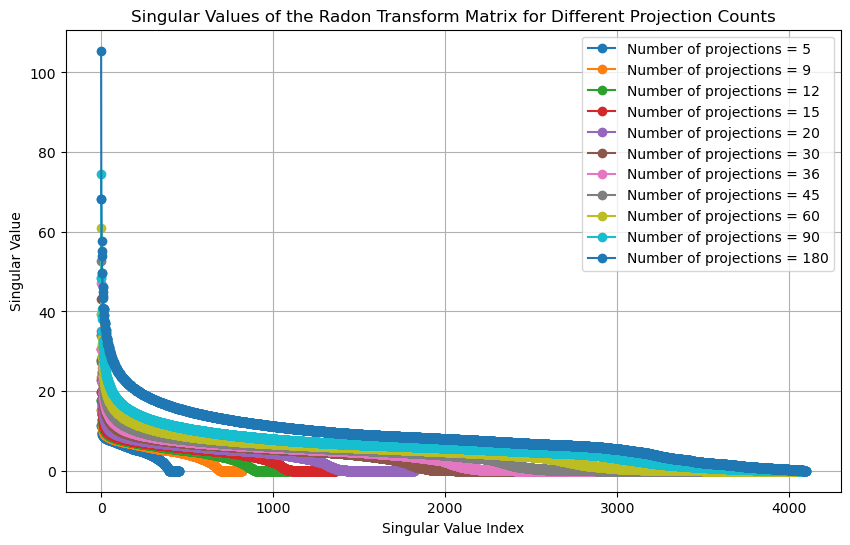

In [23]:
# Plot the singular values for different projection counts without log scale
plt.figure(figsize=(10, 6))
for num_projections, values in singular_values_dict.items():
    plt.plot(values, label=f'Number of projections = {num_projections}', marker='o')

plt.title('Singular Values of the Radon Transform Matrix for Different Projection Counts')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value')
plt.legend()
plt.grid(True)
plt.show()

### ii) Keeping the number of projection the same, but varying the range to being less than 0 →180 (i.e. limited angle). 

Sinogram for pixel 0: max=0.964758574962616
Sinogram for pixel 1: max=0.9470435976982117
Sinogram for pixel 2: max=0.9410683512687683
Sinogram for pixel 3: max=0.9581779837608337
Sinogram for pixel 4: max=0.923917829990387
Sinogram for pixel 5: max=0.9494251608848572
Sinogram for pixel 6: max=0.975923478603363
Sinogram for pixel 7: max=0.9321160912513733
Sinogram for pixel 8: max=0.942740797996521
Sinogram for pixel 9: max=0.9706564545631409
Sinogram for pixel 10: max=0.9461467266082764
Sinogram for pixel 11: max=0.9450007081031799
Sinogram for pixel 12: max=0.9416047930717468
Sinogram for pixel 13: max=0.9452621936798096
Sinogram for pixel 14: max=0.9615251421928406
Sinogram for pixel 15: max=0.9552172422409058
Sinogram for pixel 16: max=0.9785391092300415
Sinogram for pixel 17: max=0.9866151213645935
Sinogram for pixel 18: max=0.9888951778411865
Sinogram for pixel 19: max=0.9722294807434082
Sinogram for pixel 20: max=0.9694835543632507
Sinogram for pixel 21: max=0.9682124853134155
Si

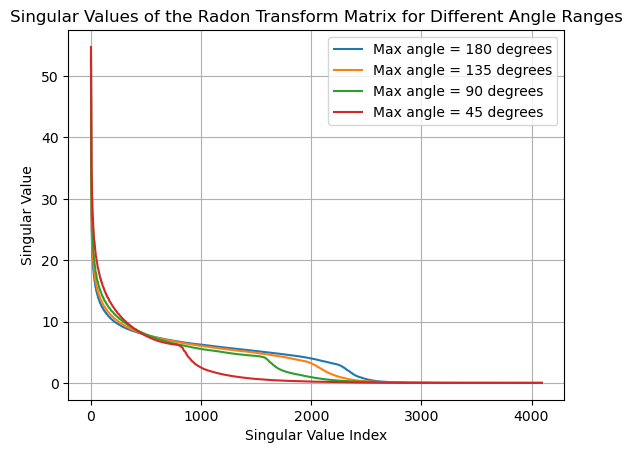

In [24]:
# Define parameters
img_size_q2 = 64
num_projections = 45
angle_ranges = [180, 135, 90, 45]  # Angle ranges in degrees

# Singular values storage
singular_values_by_angle = {}

# Compute singular values for different angle ranges
for max_angle in angle_ranges:
    max_angle_rad = np.radians(max_angle)  # Convert degrees to radians
    A = create_radon_matrix(img_size_q2, num_projections, max_angle_rad)
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    singular_values_by_angle[max_angle] = s
    plt.plot(s, label=f'Max angle = {max_angle} degrees')

# Plot configuration
plt.title('Singular Values of the Radon Transform Matrix for Different Angle Ranges')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value')
plt.legend()
plt.grid(True)
plt.show()

# Q3 Implement a matrix-free regularised least-squares solver for the Radon Transform.

In [88]:
# Add Gaussian noise to sinogram
theta = 0.5 # We use the global noise level setting in Q3  

In [54]:
def forward_radon_operator(image, angles=np.linspace(0, np.pi, 180, endpoint=False)):
    # Set the geometry of the volume and the projector
    vol_geom = astra.create_vol_geom(image.shape)
    proj_geom = astra.create_proj_geom('parallel', 1.0, max(image.shape), angles)

    # Create the projector and perform the Radon transform
    projector_id = astra.create_projector('strip', proj_geom, vol_geom)
    sinogram_id, sinogram = astra.create_sino(image, projector_id)
    astra.projector.delete(projector_id)
    astra.data2d.delete(sinogram_id)
    return sinogram

def adjoint_radon_operator(sinogram, output_shape, angles=np.linspace(0, np.pi, 180, endpoint=False)):
    # Use the same angles and geometry as the forward operation
    vol_geom = astra.create_vol_geom(output_shape)
    proj_geom = astra.create_proj_geom('parallel', 1.0, max(output_shape), angles)

    # Create the sinogram ID and the volume to store the reconstructed data
    sinogram_id = astra.data2d.create('-sino', proj_geom, data=sinogram)
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Create the projector
    projector_id = astra.create_projector('strip', proj_geom, vol_geom)

    # Set up the configuration for backprojection
    cfg = astra.astra_dict('BP')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = projector_id

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)

    # Retrieve the reconstructed image
    reconstructed_image = astra.data2d.get(rec_id)

    # Clean up each resource separately
    astra.data2d.delete(sinogram_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(projector_id)
    
    return reconstructed_image


In [55]:
def regularized_least_squares_solver(image, alpha, angles= np.linspace(0, np.pi, 180, endpoint=False), L=None,return_g=False):
    # Define the matrix-free operators
    def matvec(v):
        return adjoint_radon_operator(forward_radon_operator(v.reshape(image.shape)), image.shape).flatten() + alpha * (L @ v)

    A = LinearOperator((image.size, image.size), matvec=matvec, dtype=np.float32)
    g = forward_radon_operator(image, angles)

    g_noisy = g + theta * np.random.randn(*g.shape)
    b = adjoint_radon_operator(g_noisy, image.shape, angles).flatten()

    # Solve the regularized least squares problem
    f_star, exit_code = cg(A, b,maxiter=100)

    if return_g:
        return f_star.reshape(image.shape), exit_code,g_noisy
    else:
        return f_star.reshape(image.shape), exit_code



In [72]:


from scipy.optimize import minimize

def objective_function(alpha, image, angles, L,sigma):
    """Objective function to be minimized, based on the residual norm and regularization."""
    f_rec, _ = regularized_least_squares_solver(image, alpha, angles, L)
    residual = np.linalg.norm(forward_radon_operator(image, angles) - forward_radon_operator(f_rec, angles))
    return residual  - sigma**2

def find_optimal_alpha(image, angles, L, alpha_bounds=(0.001, 10), max_iter=100,sigma=0.05):
    """Find the optimal alpha using a logarithmic scale search if specified."""
    
    result = minimize(lambda alpha: objective_function(alpha, image, angles, L,sigma),
                        x0=np.mean(alpha_bounds), bounds=[alpha_bounds], options={'maxiter': max_iter})
    optimal_alpha = result.x

    return optimal_alpha





### zero-order Tikhonov regularization

### first-order Tikhonov regularization

In [56]:
def first_order_tikhonov_matrix(n):
    """Create a first-order Tikhonov regularization matrix for an n x n image."""
    D = np.eye(n) - np.eye(n, k=1)
    D[-1, -1] = 0  # handling boundary conditions appropriately
    L = np.kron(np.eye(n), D) + np.kron(D, np.eye(n))
    return L


## Comparison with the filtered-backprojection method 

In [92]:
def perform_backprojection(sinogram_id, vol_geom, proj_geom):
    """Perform filtered backprojection."""
    # Create the projector
    projector_id = astra.create_projector('strip', proj_geom, vol_geom)
    
    # Create the configuration for the filtered backprojection
    rec_id = astra.data2d.create('-vol', vol_geom)
    cfg = astra.astra_dict('FBP')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = projector_id  # Use the projector ID returned by astra.create_projector
    
    # Create and run the reconstruction algorithm
    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)
    
    # Retrieve the reconstructed image and clean up resources
    reconstructed_image = astra.data2d.get(rec_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)
    astra.projector.delete(projector_id)
    
    return reconstructed_image


### Case 1 : full range but small number of angles,

In [93]:

f_true = np.load('SLphan.npy')

vol_geom = astra.create_vol_geom(f_true.shape[0], f_true.shape[0])

angles_few = np.linspace(0, np.pi, 90, endpoint=False)  # 90 angles

# print("Setting up geometry...")
proj_geom = astra.create_proj_geom('parallel', 1.0, f_true.shape[0], angles_few)

print("Computing forward operation...")
sinogram = forward_radon_operator(f_true, angles_few)

print("Adding noise...")
# Right-hand side: Radon transform of the noisy image simulation
noisy_sinogram = forward_radon_operator(f_true, angles_few) + np.random.normal(0, theta, (len(angles_few), f_true.shape[0]))

noisy_sinogram_id = astra.data2d.create('-sino', proj_geom, noisy_sinogram)

# Filtered backprojection
print("Performing backprojection...")
fbp_image = perform_backprojection(noisy_sinogram_id, vol_geom, proj_geom)


Computing forward operation...
Adding noise...
Performing backprojection...


In [94]:
# Zero-order Tikhonov
print("Solving zero-order regularization...")
L_zero = np.eye(f_true.size)
# optimal_alpha_zero = find_optimal_alpha(f_true, angles_few, L_zero, alpha_bounds=(0.225,0.275),sigma=theta)
# print(f"Optimal Alpha: {optimal_alpha_zero}")
optimal_alpha_zero = 0.225
restored_image_zero, _ = regularized_least_squares_solver(f_true, optimal_alpha_zero, angles_few, L_zero)

Solving zero-order regularization...


In [95]:

# First-order Tikhonov
print("Solving first-order regularization...")
n = int(np.sqrt(f_true.size))  # Assuming f_true is a square image
L_first = first_order_tikhonov_matrix(n)
# optimal_alpha_first = find_optimal_alpha(f_true, angles_few, L_first, alpha_bounds=(0.01,0.1),sigma=theta)  # =0.05

optimal_alpha_first = 0.05
print(f"Optimal alpha found: {optimal_alpha_first}")
restored_image_first, _ = regularized_least_squares_solver(f_true, optimal_alpha_first, angles_few, L_first)

Solving first-order regularization...
Optimal alpha found: 0.05


Visualizing results...


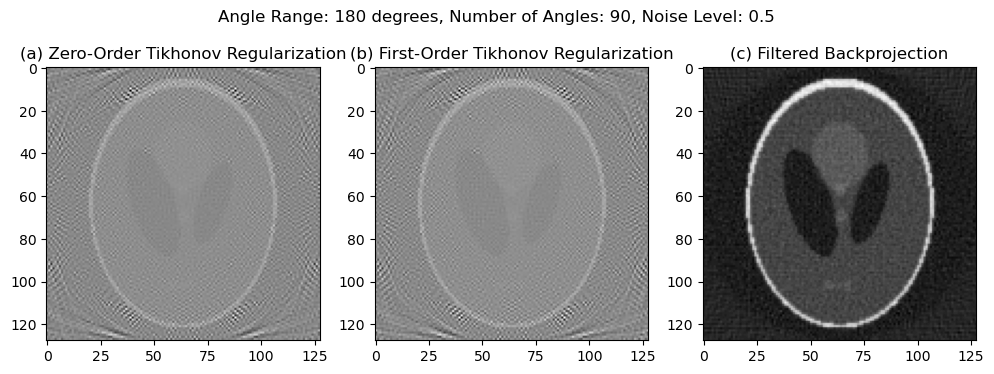

In [96]:

angle_range = "180"

num_angles= "90"

## Visualization
print("Visualizing results...")
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(restored_image_zero, cmap='gray')
plt.title('(a) Zero-Order Tikhonov Regularization')

plt.subplot(1, 3, 2)
plt.imshow(restored_image_first, cmap='gray')
plt.title('(b) First-Order Tikhonov Regularization')

plt.subplot(1, 3, 3)
plt.imshow(fbp_image, cmap='gray')
plt.title('(c) Filtered Backprojection')

plt.suptitle(f'Angle Range: {angle_range} degrees, Number of Angles: {num_angles}, Noise Level: {theta}')
plt.show()


### Case 2: limited angles

Adding noise...
Visualizing results...


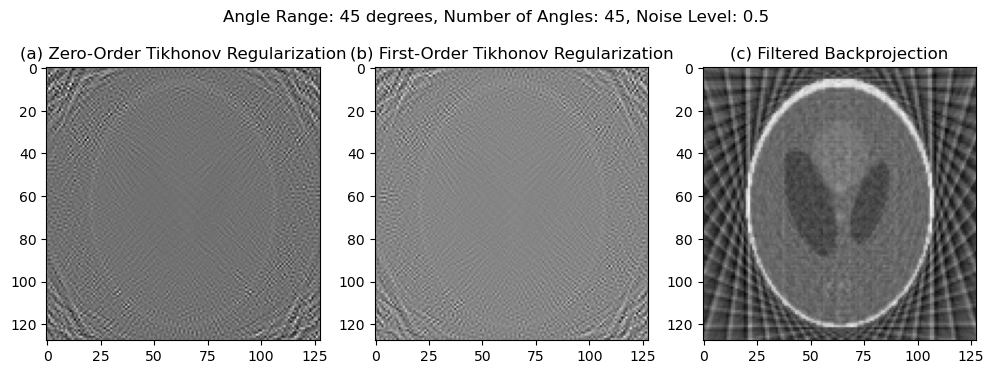

In [97]:

f_true = np.load('SLphan.npy')
vol_geom = astra.create_vol_geom(f_true.shape[0], f_true.shape[0])

#angles_limited = np.linspace(0, np.pi / 4, 45, endpoint=False)  # 45 angles, total coverage of 45 degrees
angles_limited = np.linspace(0, 45, endpoint=False, num=45)  

proj_geom = astra.create_proj_geom('parallel', 1.0, f_true.shape[0], angles_limited)



print("Adding noise...")
# Right-hand side: Radon transform of the noisy image simulation
noisy_sinogram = forward_radon_operator(f_true, angles_limited) + np.random.normal(0, 0.05, (len(angles_limited), f_true.shape[0]))


noisy_sinogram_id = astra.data2d.create('-sino', proj_geom, noisy_sinogram)

# Filtered backprojection
fbp_image = perform_backprojection(noisy_sinogram_id, vol_geom, proj_geom)

# Zero-order Tikhonov
L_zero = np.eye(f_true.size)
restored_image_zero, _ = regularized_least_squares_solver(f_true, optimal_alpha_zero, angles_limited, L_zero)

#First-order Tikhonov
L_first = first_order_tikhonov_matrix(f_true.shape[0])
restored_image_first, _ = regularized_least_squares_solver(f_true, optimal_alpha_first, angles_limited, L_first)


angle_range = "45"

num_angles= "45"

## Visualization
print("Visualizing results...")
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(restored_image_zero, cmap='gray')
plt.title('(a) Zero-Order Tikhonov Regularization')

plt.subplot(1, 3, 2)
plt.imshow(restored_image_first, cmap='gray')
plt.title('(b) First-Order Tikhonov Regularization')

plt.subplot(1, 3, 3)
plt.imshow(fbp_image, cmap='gray')
plt.title('(c) Filtered Backprojection')

plt.suptitle(f'Angle Range: {angle_range} degrees, Number of Angles: {num_angles}, Noise Level: {theta}')
plt.show()

# Q4 Write a Haar wavelet denoiser.

### Take any (monochrome) image of your choice. Calculate the Haar wavelet transform of this image. Plot some of the coefficients and explain what you see

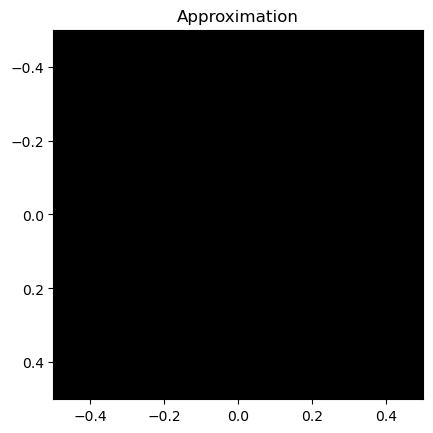

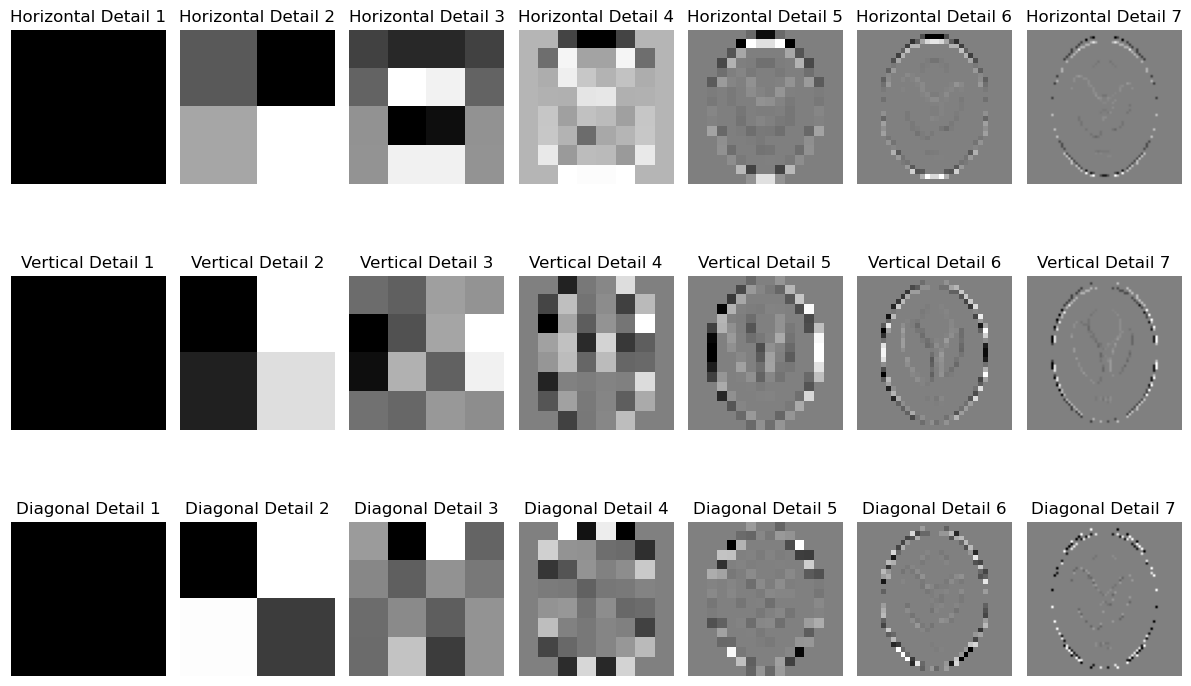

In [ ]:

# Load the image
img = np.load('SLphan.npy')

# Compute Haar wavelet coefficients
coeffs = pywt.wavedec2(img, 'haar', level=7)


plt.imshow(coeffs[0], cmap='gray')
plt.title("Approximation")
plt.show()


# Visualize the coefficients at different scales
plt.figure(figsize=(12, 8))
for i, (cH, cV, cD) in enumerate(coeffs[1:], start=1):
    plt.subplot(3, 7, i)
    plt.imshow(cH, cmap='gray')
    plt.title(f'Horizontal Detail {i}')
    plt.axis('off')
    plt.subplot(3, 7, i + 7)
    plt.imshow(cV, cmap='gray')
    plt.title(f'Vertical Detail {i}')
    plt.axis('off')
    plt.subplot(3, 7, i + 14)
    plt.imshow(cD, cmap='gray')
    plt.title(f'Diagonal Detail {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()



### Reconstruct the image from the coefficients by calling the inverse wavelet transform. Check if your reconstructed image coincides with the original.

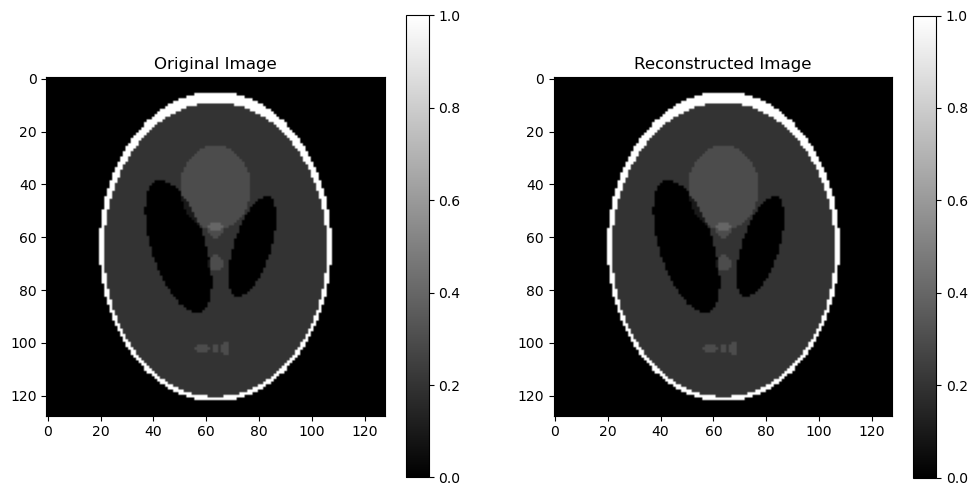

Max difference between original and reconstructed image: 1.3322676295501878e-15


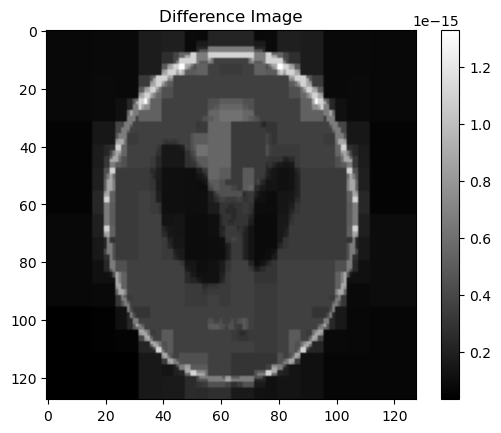

In [ ]:

# Reconstruct the image from the wavelet coefficients
img_reconstructed = pywt.waverec2(coeffs, 'haar')

# Display the original and reconstructed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(img_reconstructed, cmap='gray')
plt.title('Reconstructed Image')
plt.colorbar()

plt.show()

# Compute and display the difference
difference = np.abs(img - img_reconstructed)
print("Max difference between original and reconstructed image:", np.max(difference))

plt.figure()
plt.imshow(difference, cmap='gray')
plt.title('Difference Image')
plt.colorbar()
plt.show()


### Write a function that implements thresholding for a given range (the different scales of your wavelet coefficients) and threshold parameter, and form a modified image by performing the inverse wavelet transform on the thresholded coefficients.

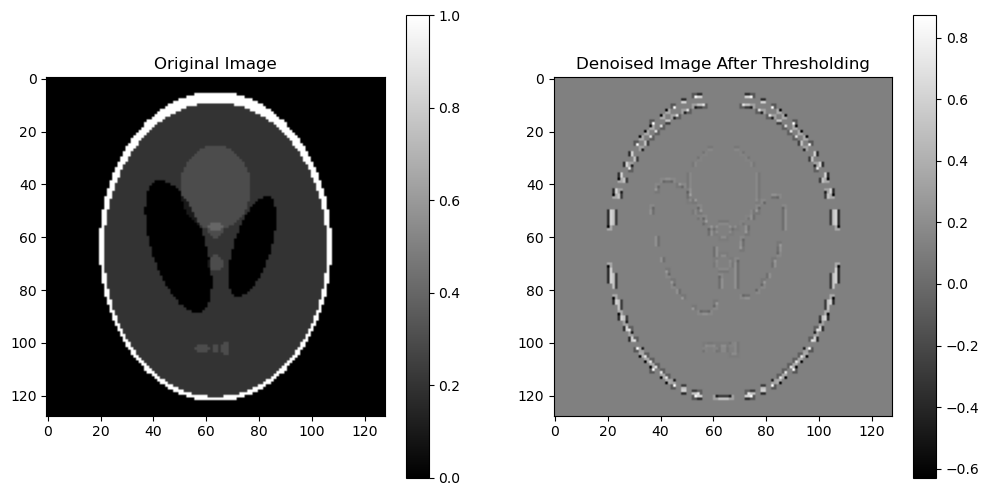

In [ ]:

def threshold_wavelet_coeffs(coeffs, t_range, t_val):
    """Threshold wavelet coefficients at specified scales."""
    # Copy the list of coefficients so the original is not modified
    coeffs_t = coeffs.copy()
    # Process only the detail coefficients, skip the approximation coefficients at index 0
    for i in range(1, len(coeffs)):
        if i in t_range:
            coeffs_t[i] = tuple(pywt.threshold(sub_coeff, t_val, mode='soft') for sub_coeff in coeffs[i])
    return coeffs_t

# Load the image
img = np.load('SLphan.npy')

# Compute Haar wavelet coefficients
coeffs = pywt.wavedec2(img, 'haar', level=7)

# Define the scales to threshold and the threshold value
max_range = 7
t_range = range(1, max_range)  # Threshold from scale 1 to max_range-1
threshold_value = 20  # Define a suitable threshold value

# Apply thresholding
coeffs_thresh = threshold_wavelet_coeffs(coeffs, t_range, threshold_value)

# Reconstruct the image from the thresholded coefficients
img_denoised = pywt.waverec2(coeffs_thresh, 'haar')

# Display original and denoised images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(img_denoised, cmap='gray')
plt.title('Denoised Image After Thresholding')
plt.colorbar()

plt.show()


### Create a noisy version of your original image and perform denoising by thresholding of the wavelet coefficients. Investigate the effect of changing the range and the threshold parameter.

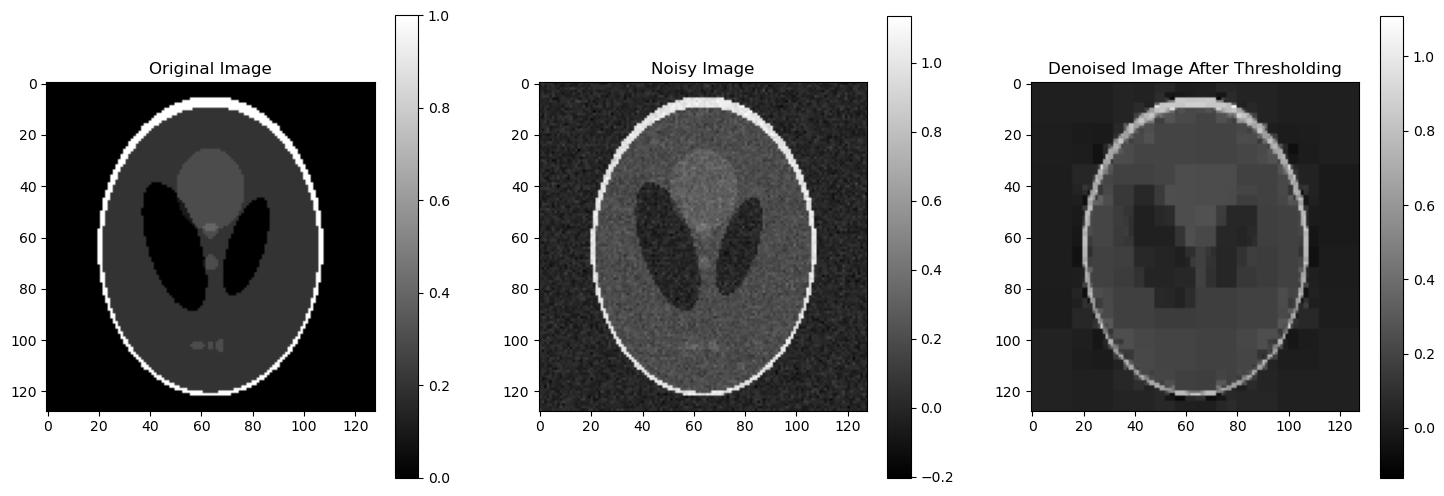

In [ ]:

def add_gaussian_noise(image, sigma=0.1):
    """Add Gaussian noise to an image."""
    noise = np.random.normal(0, sigma, image.shape)
    noisy_image = image + noise
    return noisy_image

def calculate_threshold(coeffs, percentile=95):
    """Calculate the threshold for wavelet coefficients based on a percentile."""
    detail_coeffs = []
    for level in coeffs[1:]:
        detail_coeffs.extend(np.abs(level[0]).ravel())  # Horizontal detail coefficients
        detail_coeffs.extend(np.abs(level[1]).ravel())  # Vertical detail coefficients
        detail_coeffs.extend(np.abs(level[2]).ravel())  # Diagonal detail coefficients
    threshold = np.percentile(detail_coeffs, percentile)
    return threshold

def threshold_wavelet_coeffs(coeffs, t_range, t_val):
    """Threshold wavelet coefficients at specified scales."""
    coeffs_t = coeffs.copy()
    for i in range(1, len(coeffs)):
        if i in t_range:
            coeffs_t[i] = tuple(pywt.threshold(sub_coeff, t_val, mode='soft') for sub_coeff in coeffs[i])
    return coeffs_t

def threshold_and_reconstruct(coeffs, t_range, t_val):
    """Apply thresholding and reconstruct the image."""
    coeffs_t = threshold_wavelet_coeffs(coeffs, t_range, t_val)
    return pywt.waverec2(coeffs_t, 'haar')

# Load the image and compute its wavelet coefficients
img = np.load('SLphan.npy')
coeffs = pywt.wavedec2(img, 'haar', level=7)

# Add Gaussian noise to the image
sigma = 0.05  # Noise level
img_noisy = add_gaussian_noise(img, sigma)

# Compute wavelet coefficients of the noisy image
coeffs_noisy = pywt.wavedec2(img_noisy, 'haar', level=7)

# Determine the threshold using the 95th percentile
threshold_value = calculate_threshold(coeffs_noisy, percentile=95)

# Define the scales to threshold
t_range = range(1, 8)  # Apply thresholding to all scales

# Reconstruct the image after thresholding
img_denoised = threshold_and_reconstruct(coeffs_noisy, t_range, threshold_value)

# Display original, noisy, and denoised images
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(img_noisy, cmap='gray')
plt.title('Noisy Image')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(img_denoised, cmap='gray')
plt.title('Denoised Image After Thresholding')
plt.colorbar()

plt.show()


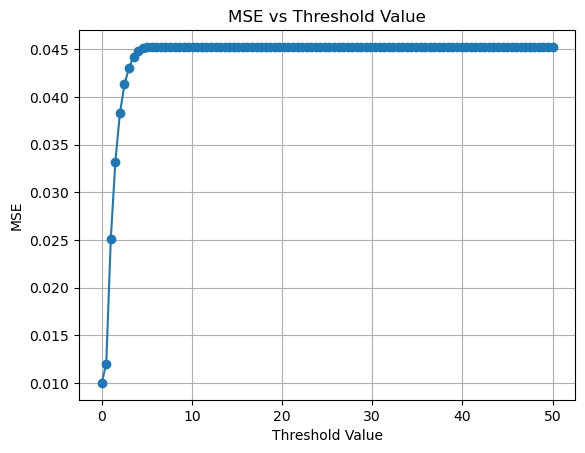

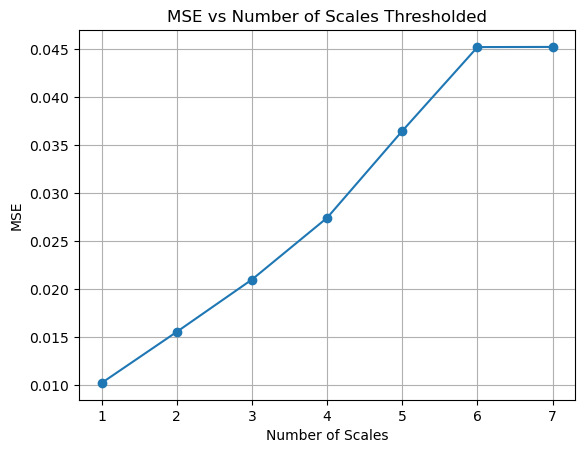

In [ ]:

def calculate_mse(original, denoised):
    """Calculate the Mean Squared Error between two images."""
    return np.mean((original - denoised) ** 2)

def threshold_wavelet_coeffs(coeffs, t_range, t_val):
    """Threshold wavelet coefficients at specified scales."""
    coeffs_t = coeffs.copy()
    for i in range(1, len(coeffs)):
        if i in t_range:
            coeffs_t[i] = tuple(pywt.threshold(sub_coeff, t_val, mode='soft') for sub_coeff in coeffs[i])
    return coeffs_t

def plot_mse_vs_threshold(image, coeffs, max_scale, thresholds):
    """Plot MSE vs. threshold values for a fixed range of scales."""
    mses = []
    t_range = range(1, max_scale + 1)  # Apply thresholding up to the max_scale
    for t_val in thresholds:
        coeffs_t = threshold_wavelet_coeffs(coeffs, t_range, t_val)
        img_denoised = pywt.waverec2(coeffs_t, 'haar')
        mse = calculate_mse(image, img_denoised)
        mses.append(mse)
    
    plt.figure()
    plt.plot(thresholds, mses, marker='o')
    plt.title('MSE vs Threshold Value')
    plt.xlabel('Threshold Value')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.show()

def plot_mse_vs_scales(image, coeffs, threshold, max_scale):
    """Plot MSE vs. number of scales used for thresholding."""
    mses = []
    scales = range(1, max_scale + 1)
    for scale in scales:
        t_range = range(1, scale + 1)
        coeffs_t = threshold_wavelet_coeffs(coeffs, t_range, threshold)
        img_denoised = pywt.waverec2(coeffs_t, 'haar')
        mse = calculate_mse(image, img_denoised)
        mses.append(mse)
    
    plt.figure()
    plt.plot(scales, mses, marker='o')
    plt.title('MSE vs Number of Scales Thresholded')
    plt.xlabel('Number of Scales')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.show()

# Load the image
img = np.load('SLphan.npy')

# Compute Haar wavelet coefficients for the noisy image
sigma = 0.1  # Noise standard deviation
noisy_img = img + np.random.normal(0, sigma, img.shape)
coeffs = pywt.wavedec2(noisy_img, 'haar', level=7)

# Define thresholds and scales for testing
thresholds = np.linspace(0, 50, 100)  # Threshold values
max_scale = 7  # Maximum scale level from the wavelet decomposition

# Plot MSE vs. threshold for a fixed range of scales (all scales)
plot_mse_vs_threshold(img, coeffs, max_scale, thresholds)

# Use a fixed threshold value and plot MSE across different numbers of scales
fixed_threshold = 20  # Example fixed threshold value
plot_mse_vs_scales(img, coeffs, fixed_threshold, max_scale)


In [ ]:

def add_gaussian_noise(image, sigma=0.05):
    """Add Gaussian noise to an image."""
    noise = np.random.normal(0, sigma, image.shape)
    noisy_image = image + noise
    return noisy_image

def calculate_threshold(coeffs, percentile=95):
    """Calculate the threshold value based on a percentile."""
    # Extract all detail coefficients and flatten them
    all_coeffs = []
    for detail_level in coeffs[1:]:  # Skip the approximation coefficients
        for sub_array in detail_level:
            all_coeffs.extend(np.abs(sub_array).flatten())
    # Calculate the threshold based on the percentile
    threshold = np.percentile(all_coeffs, percentile)
    return threshold

def threshold_wavelet_coeffs(coeffs, t_range, t_val):
    """Apply thresholding to wavelet coefficients at specified scales."""
    coeffs_t = [coeffs[0]]  # Start with the approximation coefficients
    # Process detail coefficients according to the specified range
    for detail_level in range(1, len(coeffs)):
        if detail_level in t_range:
            coeffs_t.append(tuple(pywt.threshold(sub_coeff, t_val, mode='soft') for sub_coeff in coeffs[detail_level]))
        else:
            coeffs_t.append(coeffs[detail_level])
    return coeffs_t

def plot_denoising_results(original, noisy, denoised, perc, r_limit):
    """Plot the original, noisy, and denoised images side by side with detailed captions."""
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(noisy, cmap='gray')
    plt.title('Noisy Image')
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(denoised, cmap='gray')
    plt.title(f'Denoised Image\nPercentile: {perc}%\nRange Limit: {r_limit}')
    plt.colorbar()

    plt.suptitle(f"Denoising with Threshold Percentile {perc}% and Range Limit {r_limit}")
    plt.show()

# Load the image
img = np.load('SLphan.npy')

# Create a noisy version of the image
noisy_img = add_gaussian_noise(img)

# Compute Haar wavelet coefficients of the noisy image
coeffs = pywt.wavedec2(noisy_img, 'haar', level=7)

# Investigate different thresholds and ranges
threshold_percentiles = [95, 90, 85, 80, 75]
range_limits = [1, 2, 3, 4, 5, 6, 7]

for perc in threshold_percentiles:
    threshold_value = calculate_threshold(coeffs, percentile=perc)
    for r_limit in range_limits:
        t_range = range(1, r_limit + 1)
        coeffs_thresh = threshold_wavelet_coeffs(coeffs, t_range, threshold_value)
        img_denoised = pywt.waverec2(coeffs_thresh, 'haar')
        plot_denoising_results(img, noisy_img, img_denoised, perc, r_limit)


# Q5 Iterative soft-thresholding for X-ray tomography.

### Define an initial iterate f0

### What is a good stopping criterion for your algorithm?

#### A good stopping criterion for an iterative algorithm like iterative soft-thresholding in X-ray tomography can be crucial for achieving an effective balance between computation time and result accuracy. Here we use Fixed Number of Iterations(num_iter).

### You need to choose a stable step size λ: Start with a small value λ << 1 and make sure that the reconstruction gets better each step. Increase it gradually to converge faster

### Can we include more prior knowledge, like non-negativity?

#### Non-negativity is a common constraint in imaging problems where the physical quantities (like density or intensity) that the image represents cannot be negative.

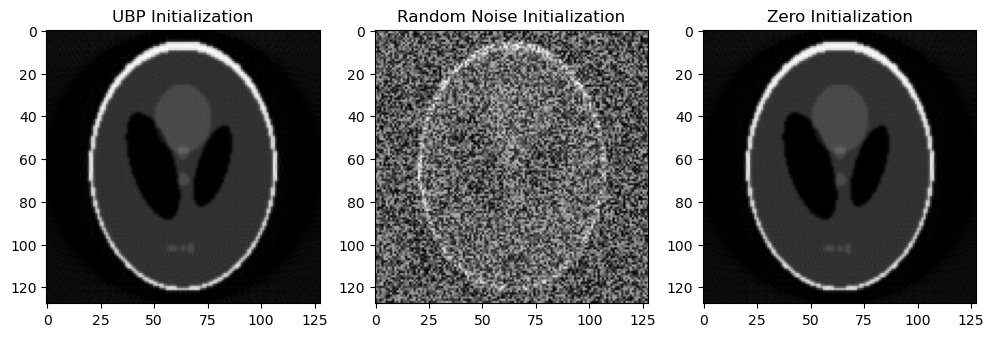

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import astra

def initialize_data(img_size, angles):
    """Initializes data by creating a sinogram from a Shepp-Logan phantom."""
    f = np.load('SLphan.npy')
    if f.shape[0] > img_size:
        start = (f.shape[0] - img_size) // 2
        f = f[start:start + img_size, start:start + img_size]
    else:
        padding = (img_size - f.shape[0]) // 2
        f = np.pad(f, padding, mode='constant', constant_values=0)
    
    
    
    vol_geom = astra.create_vol_geom(img_size, img_size)
    proj_geom = astra.create_proj_geom('parallel', 1.0, img_size, angles)
    projector_id = astra.create_projector('strip', proj_geom, vol_geom)
    sinogram_id, g = astra.create_sino(f, projector_id)
        
    
    return f, g, sinogram_id, proj_geom, vol_geom

def ista_update(fk, sinogram_id, angles, vol_geom, proj_geom, lambda_, alpha):
    """Performs one iteration of the ISTA update using ASTRA."""
    rec_id = astra.data2d.create('-vol', vol_geom, data=fk)
    cfg = astra.astra_dict('FBP')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = astra.create_projector('strip', proj_geom, vol_geom)
    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)
    
    back_projection = astra.data2d.get(rec_id)
    fk += lambda_ * back_projection
    
    coeffs = pywt.wavedec2(fk, 'haar', level=7)
    coeffs_thresh = [coeffs[0]] + [tuple(pywt.threshold(coeff, alpha * lambda_, mode='soft') for coeff in detail_coeffs) for detail_coeffs in coeffs[1:]]
    fk = pywt.waverec2(coeffs_thresh, 'haar')
    fk = np.clip(fk, 0, None) # Enforce non-negativity
    

    astra.data2d.delete(rec_id)
    astra.algorithm.delete(alg_id)
    
    return fk

def run_ista(sinogram_id, vol_geom, proj_geom, angles, lambda_, alpha, num_iter, f0):
    """Runs the ISTA algorithm."""
    fk = f0.copy()
    for i in range(num_iter):
        fk = ista_update(fk, sinogram_id, angles, vol_geom, proj_geom, lambda_, alpha)
    return fk

# Load the image and prepare the data
img_size = 128
angles = np.linspace(0, np.pi, 180, endpoint=False)
f_true, g_tomo, sinogram_id, proj_geom, vol_geom = initialize_data(img_size, angles)

# Different initializations)
rec_id = astra.data2d.create('-vol', vol_geom)
cfg = astra.astra_dict('FBP')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = astra.create_projector('strip', proj_geom, vol_geom)
alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id)
f0_ubp = astra.data2d.get(rec_id)


f0_rand = np.random.rand(img_size, img_size)
f0_zero = np.zeros((img_size, img_size))

# ISTA parameters
lambda_ = 0.01
alpha = 0.001
num_iter = 50

# Run ISTA with different initializations
f_recon_ubp = run_ista(sinogram_id, vol_geom, proj_geom, angles, lambda_, alpha, num_iter, f0_ubp)
f_recon_rand = run_ista(sinogram_id, vol_geom, proj_geom, angles, lambda_, alpha, num_iter, f0_rand)
f_recon_zero = run_ista(sinogram_id, vol_geom, proj_geom, angles, lambda_, alpha, num_iter, f0_zero)

# Visualization
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(f_recon_ubp, cmap='gray')
plt.title('UBP Initialization')
plt.subplot(132)
plt.imshow(f_recon_rand, cmap='gray')
plt.title('Random Noise Initialization')
plt.subplot(133)
plt.imshow(f_recon_zero, cmap='gray')
plt.title('Zero Initialization')
plt.show()

# Cleanup
astra.data2d.delete(sinogram_id)




Iteration 1, Improvement: 8.448821067810059
Iteration 2, Improvement: 3.0564098358154297
Iteration 3, Improvement: 3.0563974380493164
Iteration 4, Improvement: 3.056386709213257
Iteration 5, Improvement: 3.056378126144409
Iteration 6, Improvement: 3.056370496749878
Iteration 7, Improvement: 3.056366443634033
Iteration 8, Improvement: 3.056361675262451
Iteration 9, Improvement: 3.056353807449341
Iteration 10, Improvement: 3.056352376937866
Iteration 11, Improvement: 3.0563507080078125
Iteration 12, Improvement: 3.0563466548919678
Iteration 13, Improvement: 3.0563442707061768
Iteration 14, Improvement: 3.0563433170318604
Iteration 15, Improvement: 3.0563437938690186
Iteration 16, Improvement: 3.0563387870788574
Iteration 17, Improvement: 3.056340217590332
Iteration 18, Improvement: 3.056339740753174
Iteration 19, Improvement: 3.056340217590332
Iteration 20, Improvement: 3.0563361644744873
Iteration 21, Improvement: 3.0563371181488037
Iteration 22, Improvement: 3.0563344955444336
Iteratio

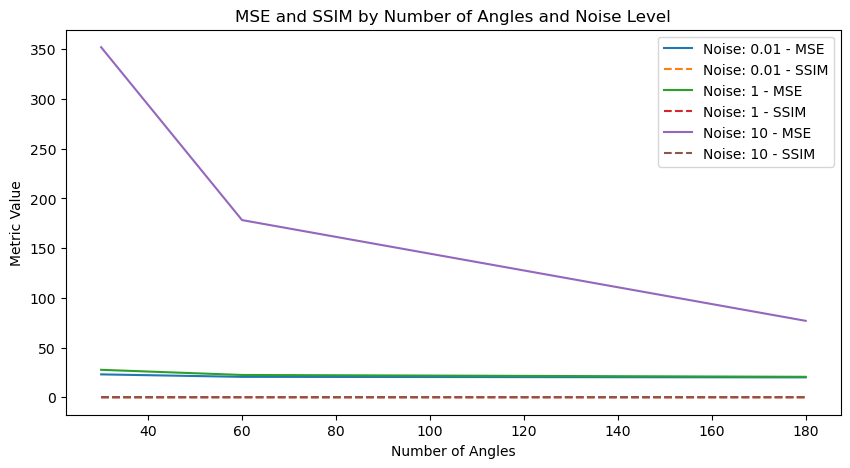

In [ ]:
import numpy as np
import astra
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def evaluate_ista(img_size, angles, noise_levels, lambda_, alpha, num_iter):
    vol_geom = astra.create_vol_geom(img_size, img_size)
    f_true = np.load('SLphan.npy')
    mse_results = []
    ssim_results = []

    for noise_level in noise_levels:
        mse_per_angle = []
        ssim_per_angle = []
        for angle_set in angles:
    
            # Generate noisy projections

            vol_geom = astra.create_vol_geom(img_size, img_size)

            proj_geom = astra.create_proj_geom('parallel', 1.0, img_size, angle_set)
            projector_id = astra.create_projector('strip', proj_geom, vol_geom)
            sinogram_id, sinogram = astra.create_sino(f_true, projector_id)


            
            # Add noise to the sinogram
            noise = np.random.normal(0, noise_level, sinogram.shape)
            noisy_sinogram = sinogram + noise
            astra.data2d.store(sinogram_id, noisy_sinogram)

            # Run the ISTA reconstruction
            f_recon = run_ista(sinogram_id, vol_geom, proj_geom, angle_set, lambda_, alpha, num_iter)

            # Calculate MSE and SSIM
            current_mse = np.mean((f_true - f_recon) ** 2)
            current_ssim = ssim(f_true, f_recon, data_range=f_true.max() - f_true.min())
            mse_per_angle.append(current_mse)
            ssim_per_angle.append(current_ssim)

            # Cleanup
            astra.data2d.delete(sinogram_id)
        
        mse_results.append(mse_per_angle)
        ssim_results.append(ssim_per_angle)

    return mse_results, ssim_results

# Define parameters
img_size = 128
noise_levels = [0.01, 1, 10]
angle_configs = [np.linspace(0, np.pi, num, endpoint=False) for num in [30, 60, 180]]

lambda_ = 0.1
alpha = 0.01
num_iter = 200

# Evaluate the algorithm
mse_results, ssim_results = evaluate_ista(img_size, angle_configs, noise_levels, lambda_, alpha, num_iter)

# Plot the MSE and SSIM results
plt.figure(figsize=(10, 5))
for idx, (mse, ssim) in enumerate(zip(mse_results, ssim_results)):
    plt.plot([30, 60, 180], mse, label=f'Noise: {noise_levels[idx]} - MSE')
    plt.plot([30, 60, 180], ssim, label=f'Noise: {noise_levels[idx]} - SSIM', linestyle='--')
plt.xlabel('Number of Angles')
plt.ylabel('Metric Value')
plt.legend()
plt.title('MSE and SSIM by Number of Angles and Noise Level')
plt.show()
